<a href="https://colab.research.google.com/github/abhi1ranjan/NLP-Practice/blob/main/Twitter_sentiment_Extaction_Analysis%2CEDA_and_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
# import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/content/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/content/kaggle/input/masks-for-wordclouds/twitter_mask4.jpg
/content/kaggle/input/masks-for-wordclouds/twitter_mask3.png
/content/kaggle/input/masks-for-wordclouds/book-logo-1.jpg
/content/kaggle/input/masks-for-wordclouds/wordcloud-man.png
/content/kaggle/input/masks-for-wordclouds/twitter_mask.png
/content/kaggle/input/masks-for-wordclouds/twitter_mask2.png
/content/kaggle/input/masks-for-wordclouds/twitter_mask3.jpg


#### Below is a helper Function which generates random colors which can be used to give different colors to your plots

In [2]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Reading the Data

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
ss = pd.read_csv('/content/sample_submission.csv')

In [4]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


As there is one null values, there is need to drop that entity.

In [6]:
train.dropna(inplace=True)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


No Null values in the test data.

## EDA

In [8]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

-> Selected_text is a subset of text

In [9]:
train.describe()

textID                                  text selected_text  \
count        27480                                 27480         27480   
unique       27480                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27480  
unique         3  
top      neutral  
freq       11117

Let's look at the distribution of tweets in the train set.

In [10]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
# print(temp)
temp.style.background_gradient(cmap='Purples')

<Axes: xlabel='sentiment', ylabel='count'>

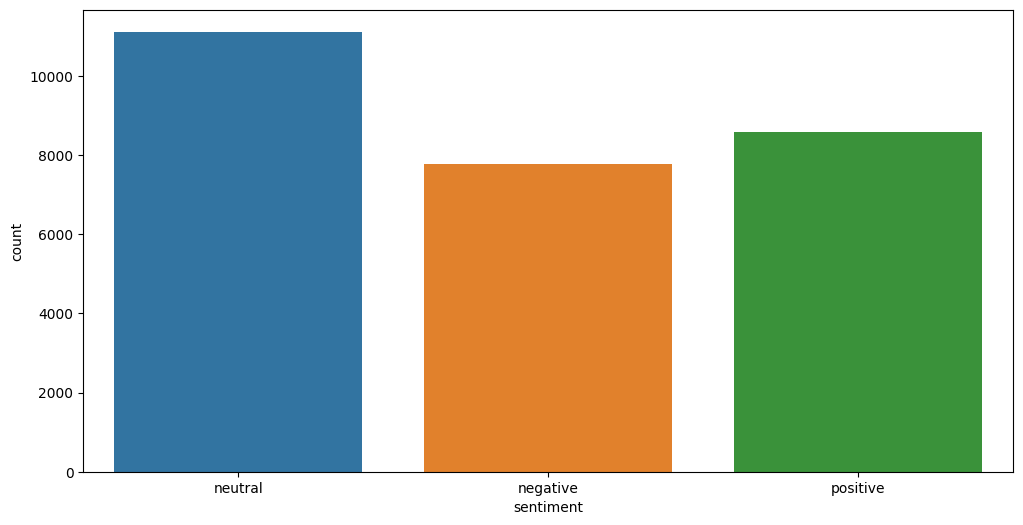

In [11]:
plt.figure(figsize = (12,6))
sns.countplot(x='sentiment', data = train)

Let's draw a funnel chart for the better visualization.

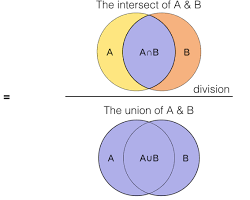

In [12]:
fig = go.Figure(go.Funnelarea(text = temp.sentiment, values = temp.text,
                              title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}))
fig.show()

# Let's point out, things we know about the data


*   selected_text is a subset of text
*   selected_text contains only one segment of text,i.e,It does not jump between two sentences. For Eg:- If text is 'Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning' The selected text can be 'my boss was not happy w/ them. Lots of fun' or 'Lots of fun' but cannot be 'Morning,vendor and my boss.
*   We know that neutral tweets have a jaccard similarity of 97 percent between text and selected_text. Reference (https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/138520)

*   there are rows where selected_text starts from between the words and thus selected_texts dont always make sense and since we do not know whether the output of test set contain these descrepancies or not ,we are not sure that preprocessing and removing punctuations would be a good idea or not. Reference (https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/138272)



# Let's generate some Meta-features.
Here we have to predict Selected_text which is a subset of text, more useful features would be:-

*    Difference in Number of words between Selected_text and text
*   Jaccard Similarity Scores between text and Selected_text.



**Let's Define what is Jaccard similarity score.**

The Jaccard Similarity score is a way to measure how similar two sets are. It's a number between 0 and 1, where 0 means the sets are completely different and 1 means they're exactly the same.

Venn Diagram for Jaccard Similarity

The formula for Jaccard Similarity (J) is given by:

J(A,B)= ∣A∪B∣/∣A∩B∣


Where:

A and B are two sets. ∣A∩B∣ is the size of the intersection of sets A and B. ∣A∪B∣ is the size of the union of sets A and B.
The Jaccard Similarity coefficient ranges from 0 to 1. A Jaccard Similarity of 0 means that the sets are completely dissimilar, and a Jaccard Similarity of 1 means that the sets are identical.

Here's a breakdown of the Jaccard Similarity calculation:

*   If A and B, both are empty sets, the Jaccard Similarity is defined to be 1.
*   If A or B, is an empty set, the Jaccard Similarity is defined to be 0.


**Applications of Jaccard Similarity include:**

*  **Text Analysis:**

   Comparing the similarity between two documents or pieces of text based on the unique words they contain.

*  **Recommendation Systems:**

   Evaluating the similarity between the sets of items liked by different users.

*  **Biology:**

   Measuring the similarity of genetic sequences or the presence/absence of genes in different species.

*  **Data Deduplication:**

   Identifying and eliminating duplicate records in databases.

*  **Image Analysis:**

   Assessing the similarity between two images based on the presence of certain features or colors.

In [13]:
def jaccard(str1, str2):
  a = set(str1.lower().split())
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [14]:
results_jaccard = []

for ind, row in train.iterrows():
  sentence1 = row.text
  sentence2 = row.selected_text

  jaccard_score = jaccard(sentence1, sentence2)
  results_jaccard.append([sentence1,sentence2,jaccard_score])

In [15]:
jaccard = pd.DataFrame(results_jaccard, columns=['text', 'selected_text','jaccard_score'])
train = train.merge(jaccard, how='outer')

In [16]:
# finding number of words in selected text
train['NumWordsST'] = train['selected_text'].apply(lambda x:len(str(x).split()))

# finding number of words in main text
train['NumWordsText'] = train['text'].apply(lambda x:len(str(x).split()))

# Difference in Number of words in main text and selected text
train['DifferenceInWords'] = train['NumWordsText'] - train['NumWordsST']

In [17]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  NumWordsST  \
0  I`d have responded, if I were going   neutral       1.000000           7   
1                             Sooo SAD  negative       0.200000           2   
2                          bullying me  negative       0.166667           2   
3                       leave me alone  negative       0.600000           3   
4                        Sons of ****,  negative       0.214286           3   

   NumWordsText  DifferenceInWords  
0             7                  0  
1            10                  8  
2             5                  3  
3             5                  2  
4            14                 11

Let's look at the distribution of Meta-features.

In [18]:
hist_data = [train['NumWordsST'], train['NumWordsText']]

groupLabels = ['Selected_Text','Text']

# create distplot with custom bin_size
fig = ff.create_distplot(hist_data, groupLabels, show_curve=False)
fig.update_layout(title_text = 'Distribution of Number of Words')
fig.update_layout( autosize = False, width = 900, height = 700, paper_bgcolor = 'LightSteelBlue')

fig.show()

The number of words plot is very interesting, as the tweets having words greater than 25 are very less and thus the number of words distribution plot is right skewed.

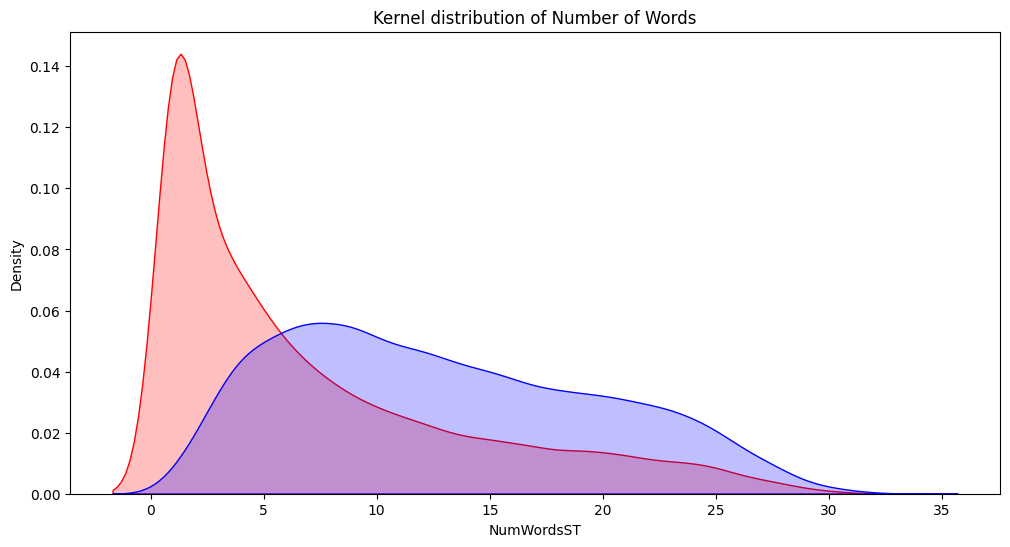

In [19]:
plt.figure(figsize=(12,6))
p1 = sns.kdeplot(train['NumWordsST'], shade = True, color='r').set_title('Kernel distribution of Number of Words')
p1 = sns.kdeplot(train['NumWordsText'], shade = True, color='b')

Now, let's see the difference in number of words and jaccard Scores across different sentiments.

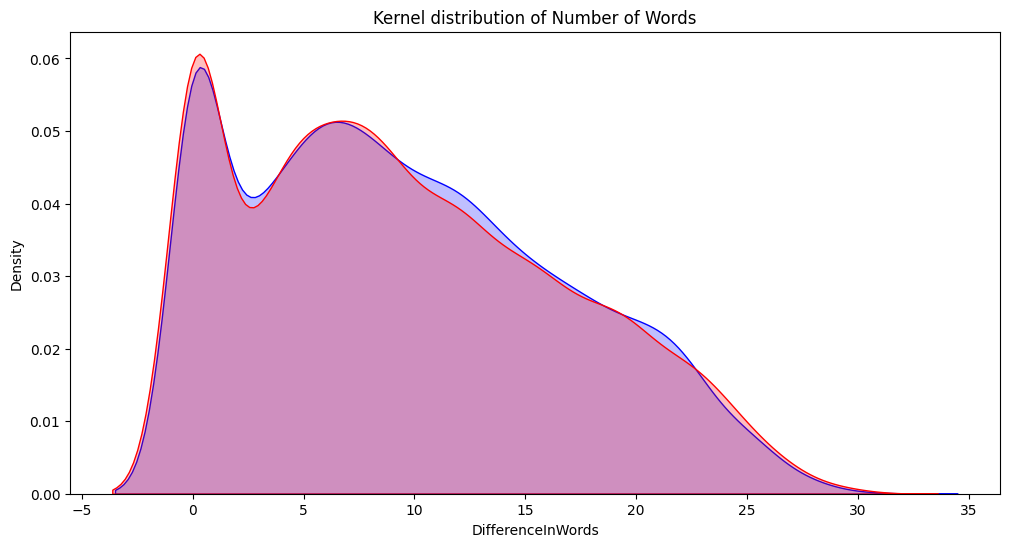

In [20]:
plt.figure(figsize=(12,6))
p1 = sns.kdeplot(train[train['sentiment'] == 'positive']['DifferenceInWords'], shade = True, color='b').set_title('Kernel distribution of Number of Words')
p1 = sns.kdeplot(train[train['sentiment'] == 'negative']['DifferenceInWords'], shade = True, color='r')

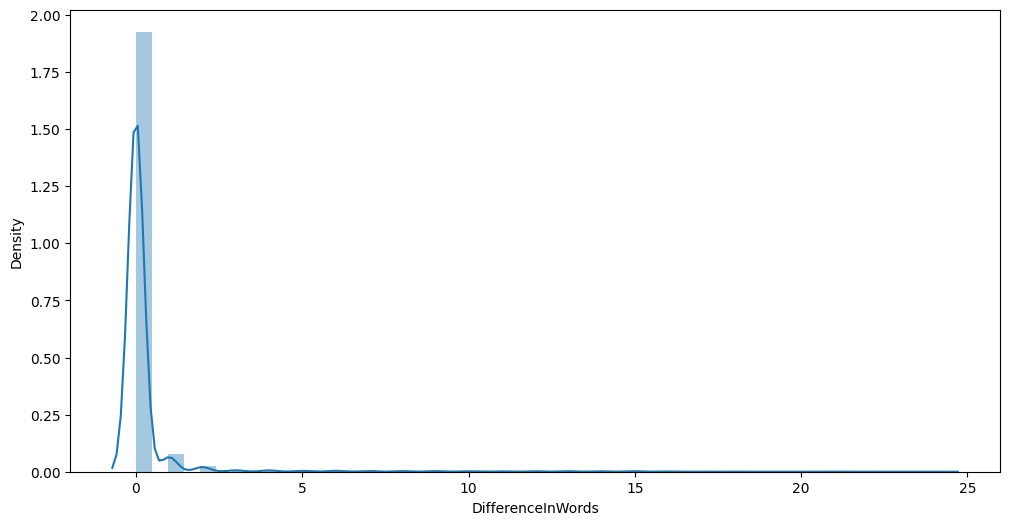

In [21]:
plt.figure(figsize=(12,6))
p1 = sns.distplot(train[train['sentiment'] == 'neutral']['DifferenceInWords'], kde=True)

As for neutral tweets, most of the values for difference in number of words were zero. If we had used the feature in starting, we would have known that text and selected text are mostly the same for neutral tweets, thus it's always important to keep the goal in mind.

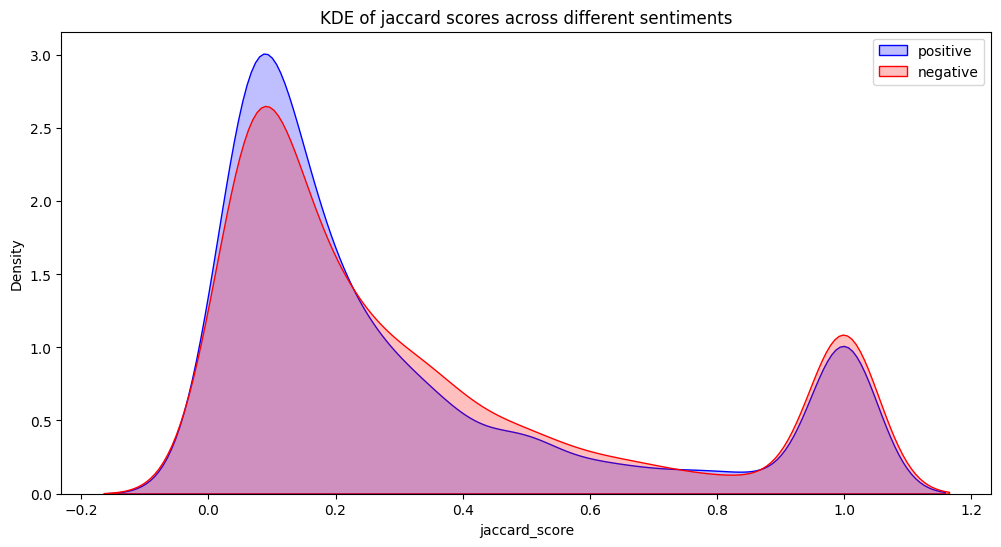

In [22]:
plt.figure(figsize=(12,6))
p1 = sns.kdeplot(train[train['sentiment'] == 'positive']['jaccard_score'], shade = True, color='b').set_title('KDE of jaccard scores across different sentiments')
p1 = sns.kdeplot(train[train['sentiment'] == 'negative']['jaccard_score'], shade = True, color='r')
plt.legend(labels=['positive', 'negative'])

We will plot distribution plot of the neutral tweets.

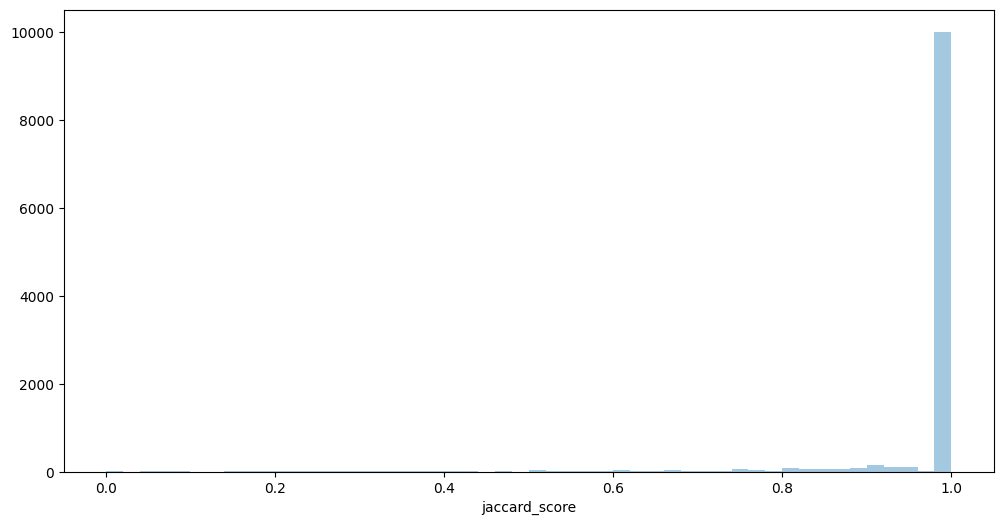

In [23]:
plt.figure(figsize=(12,6))
p1 = sns.distplot(train[train['sentiment'] == 'neutral']['jaccard_score'], kde=False)

### Conclusion from the EDA


*   Positive and Negative tweets have high Kurtosis and thus values are concentrated in two regions narrowly and have high density.
*   Neutral tweets have a low kutosis value and their is bump in density near values of 1.

*   Kutosis is a measure of how peaked distribution is and how much spread it is around that peak.

*   Skewness is measure of how much a curve deviates from a normal distribution.

*   We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1. This means that there is a cluster of tweets where there is a high similarity between text and selected_text, if we can find those clusters then we can predict text for the selected_text for those tweets irrespective of segment.




-> Let's find out those clusters

In [24]:
k = train[train['NumWordsText'] <= 2]

In [25]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

We can see that there is similarity between the text and the selected_text.

In [26]:
k[k['sentiment'] == 'positive']

textID                              text  \
68     fa2654e730                          Chilliin   
80     bbbc46889b   THANK YYYYYYYYYOOOOOOOOOOUUUUU!   
170    f3d95b57b1                      good morning   
278    89d5b3f0b5                            Thanks   
429    a78ef3e0d0                       Goodmorning   
...           ...                               ...   
26689  e80c242d6a                        Goodnight;   
26725  aad244f37d                             *hug*   
26842  a46571fe12                         congrats!   
26959  49a942e9b1                   Happy birthday.   
27292  47c474aaf1                       Good choice   

                         selected_text sentiment  jaccard_score  NumWordsST  \
68                            Chilliin  positive            1.0           1   
80     THANK YYYYYYYYYOOOOOOOOOOUUUUU!  positive            1.0           2   
170                       good morning  positive            1.0           2   
278                             Thanks  positive            1.0           1   
429                        Goodmorning  positive            1.0           1   
...                                ...       ...            ...         ...   
26689                       Goodnight;  positive            1.0           1   
26725                            *hug*  positive            1.0           1   
26842                        congrats!  positive            1.0           1   
26959                  Happy birthday.  positive            1.0           2   
27292                             Good  positive            0.5           1   

       NumWordsText  DifferenceInWords  
68                1                  0  
80                2                  0  
170               2                  0  
278               1                  0  
429               1                  0  
...             ...                ...  
26689             1                  0  
26725             1                  0  
26842             1                  0  
26959             2                  0  
27292             2                  1  

[207 rows x 8 columns]

It is evident that text is used as selected_text. We need to preprocess those text who have words less than 3.

# Cleaning the corpus

In [27]:
def cleanText(text):
  '''
    Make text lowercase, remove text in square brackets, remove links, remove puntuation
    and remove words containing numbers.
    '''

  text = str(text).lower()
  # used to find and replace text enclosed within square brackets with an empty string
  text = re.sub('\[.*?\]', '', text)
  # used to find and replace URLs in the text with an empty string, matches both HTTP and HTTPS url starting with wwww.
  text = re.sub('https?://\S+|www\.\S+', '', text)
  # used to find and remove HTML tags from the text
  text = re.sub('<.*?>+', '', text)
  # used to find and remove punctuation from the text.
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  # used to find and remove newline characters from the text
  text = re.sub('\n', '', text)
  # used to find and remove words containing digits from the text. matches any sequene of characters that contain at
  # least one digit and replaces them with an empty string
  text = re.sub('\w*\d\w*', '', text)
  return text


In [28]:
train['text'] = train['text'].apply(lambda x:cleanText(x))
train['selected_text'] = train['selected_text'].apply(lambda x:cleanText(x))

In [29]:
train.head()

textID                                               text  \
0  cb774db0d1                  id have responded if i were going   
1  549e992a42         sooo sad i will miss you here in san diego   
2  088c60f138                             my boss is bullying me   
3  9642c003ef                      what interview leave me alone   
4  358bd9e861   sons of  why couldnt they put them on the rel...   

                       selected_text sentiment  jaccard_score  NumWordsST  \
0  id have responded if i were going   neutral       1.000000           7   
1                           sooo sad  negative       0.200000           2   
2                        bullying me  negative       0.166667           2   
3                     leave me alone  negative       0.600000           3   
4                           sons of   negative       0.214286           3   

   NumWordsText  DifferenceInWords  
0             7                  0  
1            10                  8  
2             5                  3  
3             5                  2  
4            14                 11

## Most common words in our Target-Selected text

In [30]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Blues')

In [31]:
fig = px.bar(temp, x = 'count', y = 'Common_words', title = 'Common Words in Selected Text', orientation = 'h',
             width = 700, height = 700, color = 'Common_words')
fig.show()

As we can see that we haven't removed the stop words from the text. Let's remove those.

In [32]:
nltk.download('stopwords')
def removeStopwords(x):
  return [y for y in x if y not in stopwords.words('english')]

train['temp_list'] = train['temp_list'].apply(lambda x:removeStopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Purples')

In [34]:
fig = px.treemap(temp, path=['Common_words'], values = 'count', title='Tree of Most Common Words')
fig.show()

# Most Common Words in Text

Let's also look at the most common words in text

In [35]:
# list of words in every row for text
train['temp_list1'] = train['text'].apply(lambda x:str(x).split())

# removing stopwords
train['temp_list1'] = train['temp_list1'].apply(lambda x:removeStopwords(x))

In [36]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['CommonWords', 'count']
temp.style.background_gradient(cmap = 'Blues')

In [37]:
fig = px.bar(temp, x = 'count', y = 'CommonWords', title = 'Common Words in Text', orientation = 'h',
             width = 700, height = 700, color = 'CommonWords')
fig.show()

It has been observerd that Most common words in selected text and Text are almost the same, which was obvious.

# **Most Common Words Sentiments Wise**

In [38]:
PositiveSent = train[train['sentiment'] == 'positive']
NegativeSent = train[train['sentiment'] == 'negative']
NeutralSent = train[train['sentiment'] == 'neutral']

**Most Common Positive words**

In [39]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
tempPositive = pd.DataFrame(top.most_common(25))
tempPositive = tempPositive.iloc[1:,:]
tempPositive.columns = ['CommonWords', 'count']
tempPositive.style.background_gradient(cmap = 'Greens')

In [40]:
fig = px.bar(tempPositive, x = 'count', y = 'CommonWords', title = 'Most Common Positive Words in Text', orientation = 'h',
             width = 700, height = 700, color = 'CommonWords')
fig.show()

**Most Common Negative words**

In [41]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
tempNegative = pd.DataFrame(top.most_common(25))
tempNegative = tempNegative.iloc[1:,:]
tempNegative.columns = ['CommonWords', 'count']
tempNegative.style.background_gradient(cmap = 'Greens')

In [42]:
fig = px.bar(tempNegative, x = 'count', y = 'CommonWords', title = 'Most Common Negative Words in Text', orientation = 'h',
             width = 700, height = 700, color = 'CommonWords')
fig.show()

**Most Common Neutral words**

In [43]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
tempNeutral = pd.DataFrame(top.most_common(25))
tempNeutral = tempNeutral.iloc[1:,:]
tempNeutral.columns = ['CommonWords', 'count']
tempNeutral.style.background_gradient(cmap = 'Greens')

In [44]:
fig = px.bar(tempNeutral, x = 'count', y = 'CommonWords', title = 'Most Common Negative Words in Text', orientation = 'h',
             width = 700, height = 700, color = 'CommonWords')
fig.show()

In [45]:
fig = px.treemap(tempNeutral, path=['CommonWords'], values = 'count', title = 'Tree of Most Common Neutral Words')
fig.show()

We can see that words like get, go, dont, u,got, cant, lol, like are common in all the three segments. This is bit interesting because words like dont and cant, are more of negative nature and words like lol are of more positive nature.

Now, we have to find out that whether our data is labeled correct or not? To find out that, we have to do N-gram analysis.

**What is N-gram Analysis?**

It is used to analyze the frequency and distribution of sequences of n items (or words) in a given text or speech. An n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be characters, words, or other units, depending on the context.

The most common types of n-grams are:

1. Unigrams (1-grams):

    Single words or tokens.
2. Bigrams (2-grams):

    Pairs of adjacent words or tokens.
3. Trigrams (3-grams):

    Sequences of three consecutive words or tokens.
4. 4-grams, 5-grams, ... N-grams:

    Sequences of four, five, or N consecutive words or tokens.

N-gram analysis provides insights into the structure and patterns of a language, allowing researchers and practitioners to understand relationships between words, identify common phrases, and extract meaningful information from a large corpus of text.

---



Here are some key applications of N-gram analysis:

* Language Modeling:

  N-gram models are used in language modeling to predict the likelihood of a word given its context. This is foundational in applications such as speech recognition and machine translation.

* Text Prediction and Auto-Completion:

  N-grams are employed in text prediction systems to suggest the next word or phrase as a user types. Auto-completion features in various applications often use trigrams or higher-order n-grams.

* Information Retrieval:

  N-grams can be used to index and retrieve documents efficiently. Search engines may use n-grams to improve the relevance of search results.

* Spell Checking and Correction:

  N-grams can be used in spell checking algorithms to identify and correct misspelled words based on the frequency and context of n-grams.

* Text Classification and Sentiment Analysis:

  N-grams are utilized in text classification tasks, where the presence of certain word sequences may be indicative of a particular category or sentiment.

* Keyphrase Extraction:

  N-grams can help identify key phrases or important terms in a document or a collection of documents.


## Let's look at the Unique words in each segment

It will be exciting to see how unique words are to different sentiments (Positive, Negative and Neutral).

In [46]:
RawText = [word for wordList in train['temp_list1'] for word in wordList]

In [47]:
def UniqueWords(sentiment, NumWords, RawWords):
  """
    Input:
          Sentiment - Sentiment Category ( e.g., 'Neutral', 'Positive', 'Negative')
          NumWords - how many specific words do you want to see in the final result;
          RawWords - list for item in train_data[train_data.sentiment == sentiment]['temp_list1']:
    Output:
          dataframe giving information about the name of the specific ingredient and how many times it occurs in the
          choosen cuisine (in descending order based on their counts)..
  """

  allOther = []
  for item in train[train.sentiment != sentiment]['temp_list1']:
    for word in item:
      allOther.append(word)
  allOther = list(set(allOther))

  specificnonly = [x for x in RawText if x not in allOther]

  myCounter = Counter()

  for item in train[train.sentiment == sentiment]['temp_list1']:
    for word in item:
      myCounter[word] += 1
  keep = list(specificnonly)

  for word in list(myCounter):
    if word not in keep:
      del myCounter[word]

  UniqueWords = pd.DataFrame(myCounter.most_common(NumWords), columns = ['Words', 'Count'])

  return UniqueWords


Unique Positive

In [48]:
UniquePositive = UniqueWords('positive', 20, RawText)
print("The top 20 unique words in positive Tweets are:")
UniquePositive.style.background_gradient(cmap = 'Greens')

The top 20 unique words in positive Tweets are:


In [49]:
fig = px.treemap(UniquePositive, path = ['Words'], values = 'Count', title = 'Tree of Unique Positive Words')
fig.show()

In [50]:
!pip install palettable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 5.4 MB/s eta 0:00:00


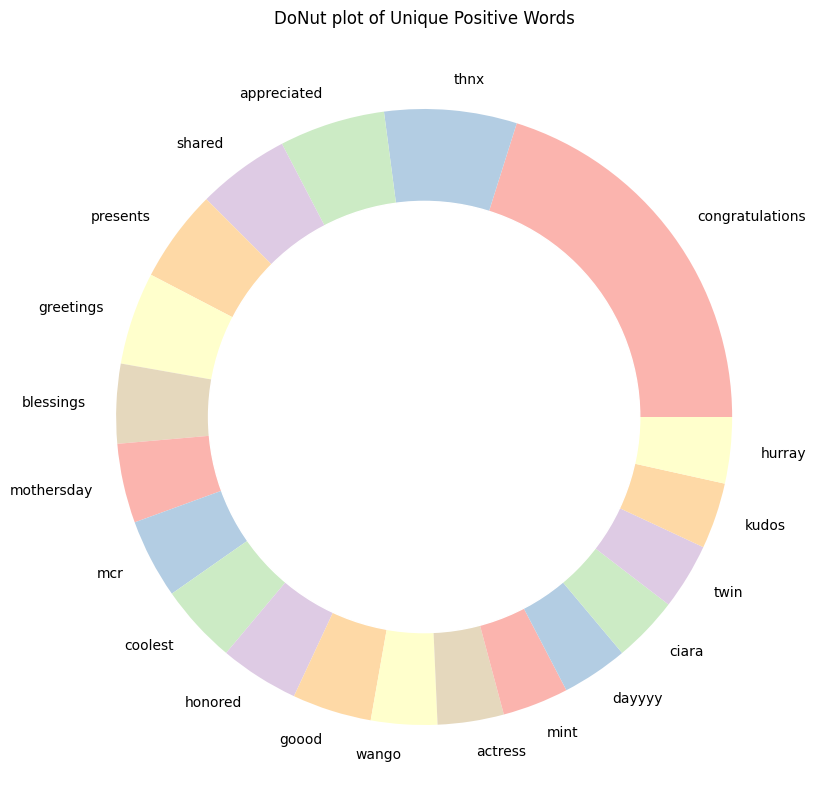

In [51]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white')
plt.pie(UniquePositive['Count'], labels = UniquePositive.Words, colors = Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut plot of Unique Positive Words')
plt.show()

**Negative Words**

In [52]:
UniqueNegative = UniqueWords('negative', 20, RawText)
print("The top 20 unique words in negative Tweets are:")
UniqueNegative.style.background_gradient(cmap = 'Reds')

The top 20 unique words in negative Tweets are:


In [53]:
fig = px.treemap(UniqueNegative, path = ['Words'], values = 'Count', title = 'Tree of Unique Negative Words')
fig.show()

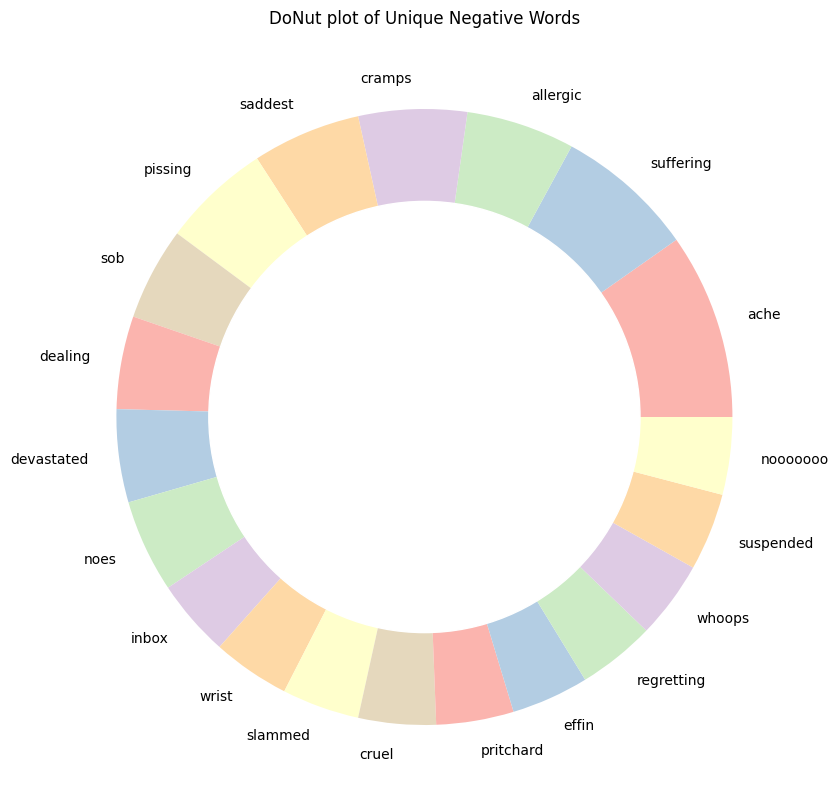

In [54]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white')
plt.pie(UniqueNegative['Count'], labels = UniqueNegative.Words, colors = Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut plot of Unique Negative Words')
plt.show()

### **Neutral** **Words**

In [55]:
UniqueNeutral = UniqueWords('neutral', 20, RawText)
print("The top 20 unique words in neutral Tweets are:")
UniqueNeutral.style.background_gradient(cmap = 'Oranges')

The top 20 unique words in neutral Tweets are:


In [56]:
fig = px.treemap(UniqueNeutral, path = ['Words'], values = 'Count', title = 'Tree of Unique Neutral Words')
fig.show()

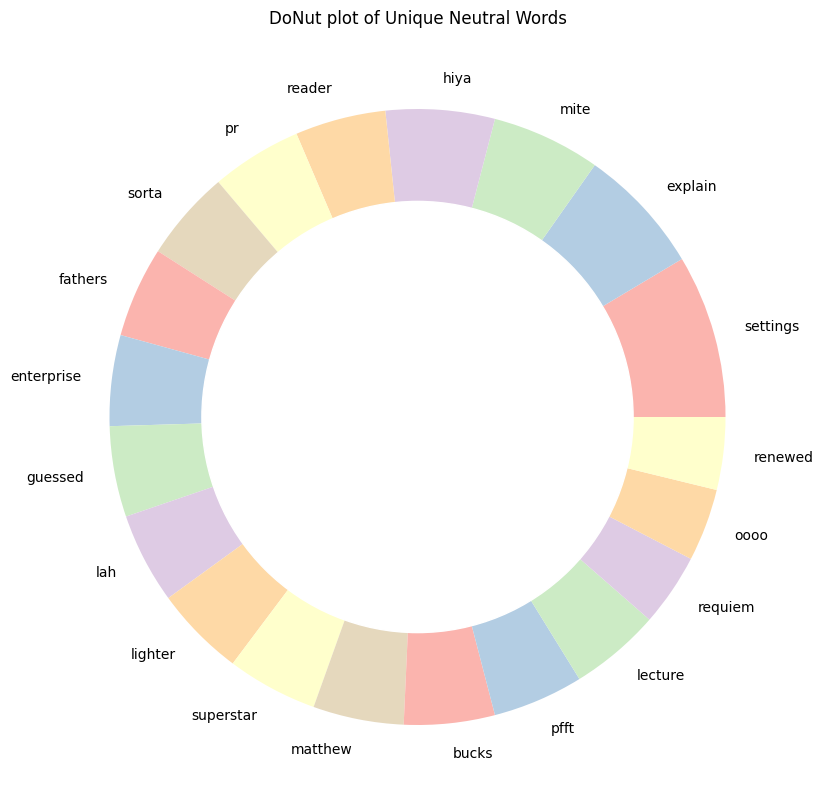

In [57]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white')
plt.pie(UniqueNeutral['Count'], labels = UniqueNeutral.Words, colors = Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut plot of Unique Neutral Words')
plt.show()

**By looking at the Unique words of each sentiment, we now have much more clarity about the data. These unique words are very strong determiners of Sentiment of the tweets.**

## Let's build WordClouds

We will be building Word Cloud of Positive, Negative and Neutral tweets.

In [58]:
def PlotWordCloud(text, mask = None, maxWords= 200, maxFontSize = 100, figure_size = (24.0,16.0), color = 'white',
                  title = None, title_size = 40, image_color = False):
  stopwords = set(STOPWORDS)
  more_stopwords = {'u', 'im'}
  stopwords = stopwords.union(more_stopwords)

  wordcloud = WordCloud (background_color= color, stopwords= stopwords, max_words= maxWords, max_font_size=maxFontSize,
                         random_state = 42, width = 400, height = 200, mask = mask)

  wordcloud.generate(str(text))

  plt.figure(figsize = figure_size)
  if image_color:
    image_colors = ImageColorGenerator(mask)
    plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = 'bilinear')
    plt.title(tile, fontdict = {'size': title_size, 'verticalalignment': 'bottom'})

  else:
    plt.imshow(wordcloud)
    plt.title(title, fontdict = {'size': title_size, 'color': 'black', 'verticalalignment':'bottom'})

  plt.axis('off')
  plt.tight_layout()

d = '/content/kaggle/input/masks-for-wordclouds/'

### **WordCloud of Neutral Tweets**

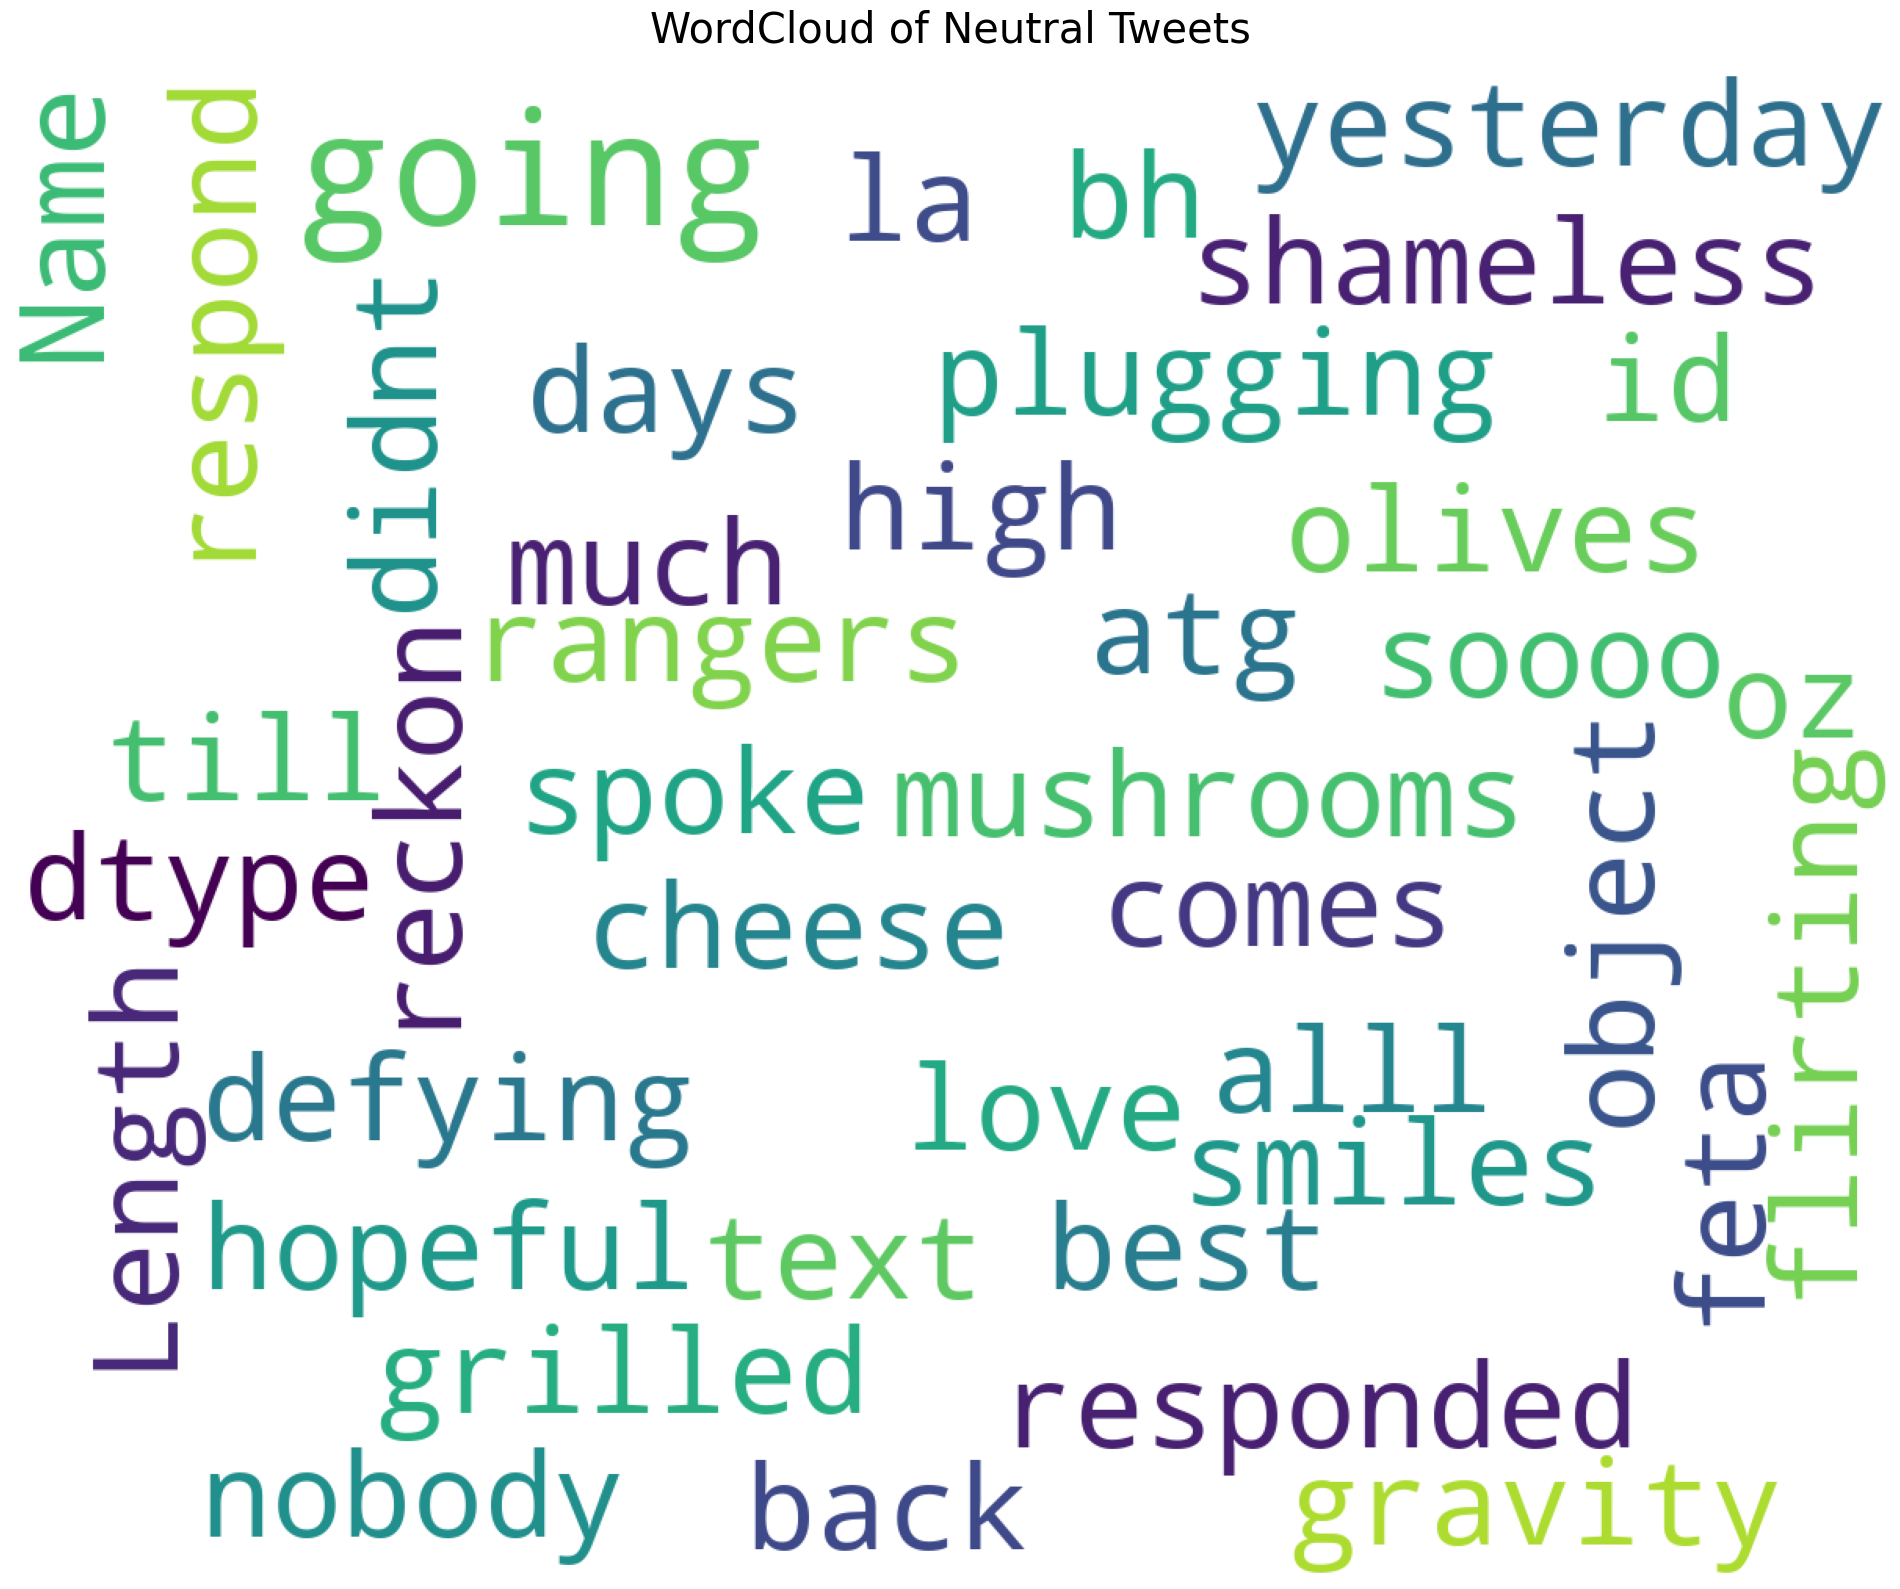

In [59]:
posMask  = np.array(Image.open(d + 'twitter_mask.png'))
PlotWordCloud (NeutralSent.text, mask = posMask, color='white', maxFontSize=100, title_size=30, title = 'WordCloud of Neutral Tweets')

WordCloud of Positive words

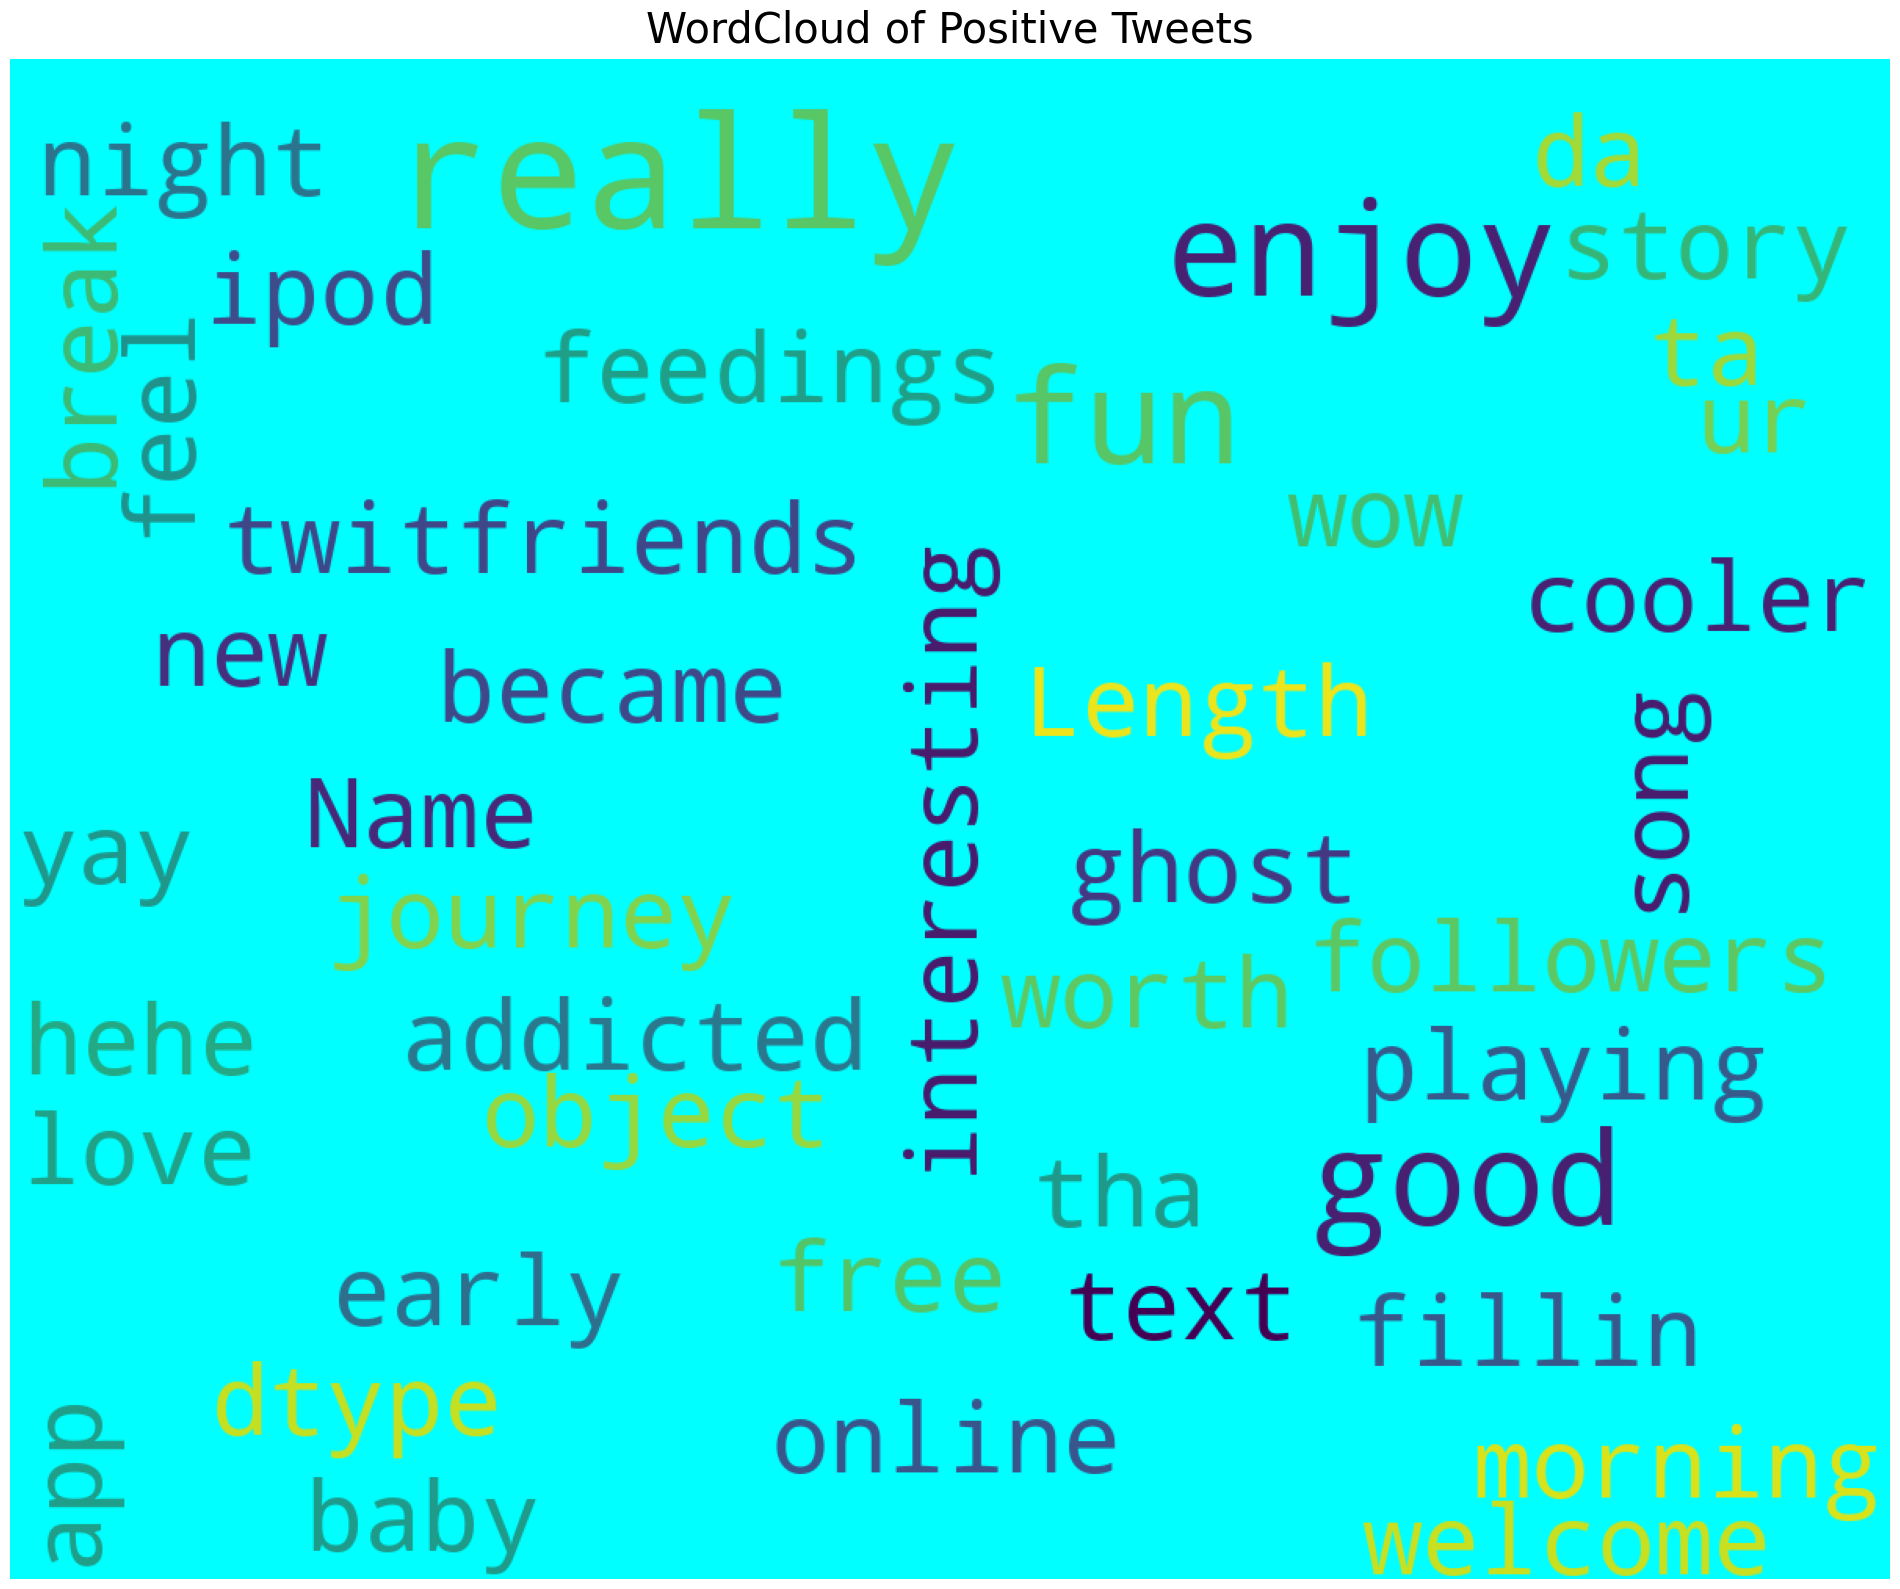

In [60]:
PlotWordCloud (PositiveSent.text, mask = posMask, color='cyan', maxFontSize=100, title_size=30, title = 'WordCloud of Positive Tweets')

WordCloud of Negative Words

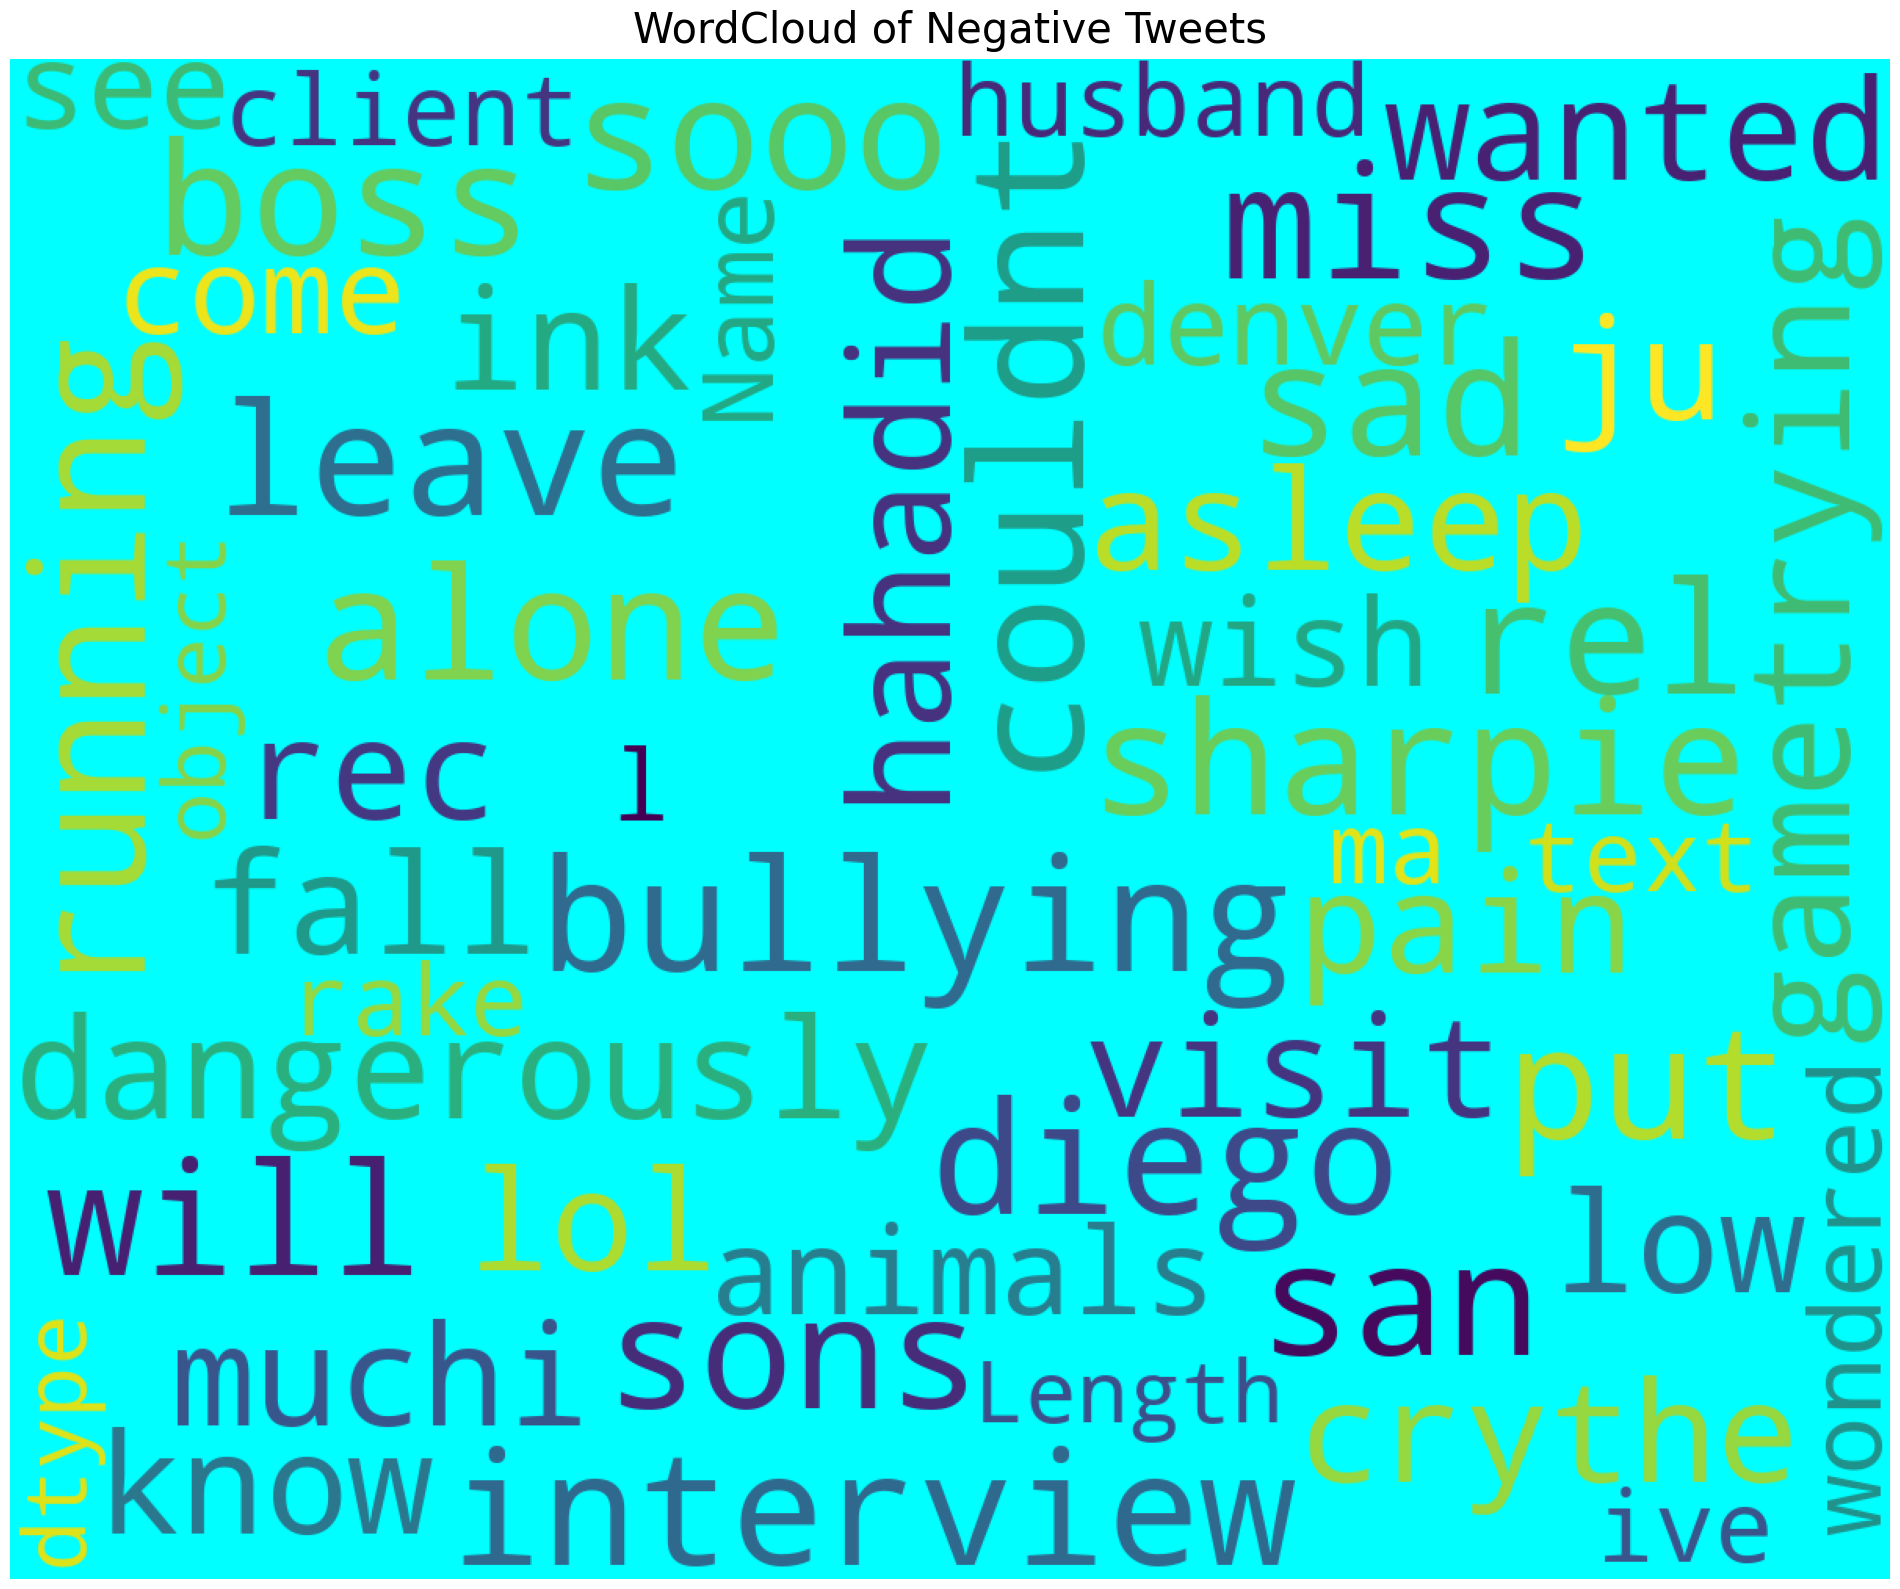

In [61]:
PlotWordCloud (NegativeSent.text, mask = posMask, color='cyan', maxFontSize=100, title_size=30, title = 'WordCloud of Negative Tweets')

## Modelling



*   Named Entity Recognition (NER)
*   Q&A Problem



### 1.   Modelling the problem as NER

NER involves finding named entities (people, places, organizations etc.,) from a group of text, and classify them into a predefined set of categories.

We will be using **spacy** for creating a custom NER model or models (separate for each sentiments).

Main ingredients of the model are:-


1.   I will use text as selected_text for all neutral tweets due to their high jaccard similarity.
2.   Will use text as selected_text for all tweets having number of words less than 3 in text as explained earlier.
3.  Will train two different models for Positive and Negative tweets.
4.  Data will not be preprocessed as selected_text contanins raw text.



In [62]:
TrainDF = pd.read_csv('/content/train.csv')
TestDF = pd.read_csv('/content/test.csv')
SubmissionDF = pd.read_csv('/content/sample_submission.csv')

In [63]:
# Number of Words in main text in train set
TrainDF['NumWordsText'] = TrainDF['text'].apply(lambda x:len(str(x).split()))

In [64]:
TrainDF = TrainDF[TrainDF['NumWordsText'] >= 3]

Creating the **spacy NER** Model

In [65]:
def saveModel(outputDir, nlp, newModelName):
  ''' This function saves model to given output directory'''

  outputDir = f'../working/{outputDir}'
  if outputDir is not None:
    if not os.path.exists(outputDir):
      os.makedirs(outputDir)
    nlp.meta['name'] = newModelName
    nlp.to_disk(outputDir)
    print('save Model to', outputDir)

In [66]:
# passModel = nlp if you want to train on top of existing model
from spacy.training.example import Example

def TrainModel (trainData, outputDir, niter = 20, model = None):
  """
  Load the model, set up the pipeline and train the entity recognizer.
  """
  if model is not None:
        nlp = spacy.load(outputDir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
  else:
      nlp = spacy.blank("en")  # create blank Language class
      print("Created blank 'en' model")

  # create the built-in pipeline components and add them to the pipeline
  # nlp.create_pipe works for built-ins that are registered with spaCy
  if "ner" not in nlp.pipe_names:
      ner = nlp.create_pipe("ner")
      nlp.add_pipe("ner", last=True)
  # otherwise, get it so we can add labels
  else:
      ner = nlp.get_pipe("ner")

  # add labels
  for _, annotations in trainData:
      for ent in annotations.get("entities"):
          ner.add_label(ent[2])

  # get names of other pipes to disable them during training
  other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
  with nlp.disable_pipes(*other_pipes):  # only train NER
      # sizes = compounding(1.0, 4.0, 1.001)
      # batch up the examples using spaCy's minibatch
      if model is None:
          nlp.begin_training()
      else:
          nlp.resume_training()


      for itn in tqdm(range(niter)):
          random.shuffle(trainData)
          batches = minibatch(trainData, size=compounding(4.0, 500.0, 1.001))
          losses = {}
          for batch in minibatch(trainData, size=compounding(4.0, 500.0, 1.001)):
            examples = []

            for text, annotation in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotation)
                examples.append(example)

            nlp.update(examples, drop=0.5, losses=losses)

          # for batch in batches:
          #     texts, annotations = zip(*batch)
          #     nlp.update(texts,  # batch of texts
          #                 annotations,  # batch of annotations
          #                 drop=0.5,   # dropout - make it harder to memorise data
          #                 losses=losses,
          #                 )
          print("Losses", losses)
  saveModel(outputDir, nlp, 'st_ner')

In [67]:
def getModelOutPath(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [68]:
def getTrainingData(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in TrainDF.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

**Training models for Positive and Negative tweets**

In [77]:
sentiment = 'positive'

train_data = getTrainingData(sentiment)
model_path = getModelOutPath(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
TrainModel(train_data, model_path, niter=50, model=None)

Created blank 'en' model


  5%|▌         | 1/20 [00:51<16:09, 51.01s/it]

Losses {'ner': 13045.176651469945}


 10%|█         | 2/20 [01:45<15:54, 53.05s/it]

Losses {'ner': 11705.71911721352}


 15%|█▌        | 3/20 [02:37<14:50, 52.37s/it]

Losses {'ner': 11380.474092848366}


 20%|██        | 4/20 [03:29<13:59, 52.48s/it]

Losses {'ner': 11237.045121461131}


 25%|██▌       | 5/20 [04:21<13:01, 52.13s/it]

Losses {'ner': 11010.377241285316}


 30%|███       | 6/20 [05:11<12:03, 51.65s/it]

Losses {'ner': 10938.982174810024}


 35%|███▌      | 7/20 [06:04<11:16, 52.04s/it]

Losses {'ner': 10805.861564975545}


 40%|████      | 8/20 [06:56<10:24, 52.04s/it]

Losses {'ner': 10738.35956482847}


 45%|████▌     | 9/20 [07:48<09:31, 51.93s/it]

Losses {'ner': 10710.323847946545}


 50%|█████     | 10/20 [08:40<08:39, 51.95s/it]

Losses {'ner': 10520.993003039031}


 55%|█████▌    | 11/20 [09:31<07:44, 51.66s/it]

Losses {'ner': 10455.964625147557}


 60%|██████    | 12/20 [10:24<06:55, 51.99s/it]

Losses {'ner': 10440.588269641066}


 65%|██████▌   | 13/20 [11:15<06:02, 51.76s/it]

Losses {'ner': 10340.445029012832}


 70%|███████   | 14/20 [12:07<05:10, 51.75s/it]

Losses {'ner': 10265.260574561984}


 75%|███████▌  | 15/20 [12:59<04:20, 52.00s/it]

Losses {'ner': 10170.988295256515}


 80%|████████  | 16/20 [13:51<03:27, 51.87s/it]

Losses {'ner': 10183.846319210545}


 85%|████████▌ | 17/20 [14:40<02:33, 51.05s/it]

Losses {'ner': 10085.621024457672}


 90%|█████████ | 18/20 [15:31<01:42, 51.09s/it]

Losses {'ner': 10058.451215557707}


 95%|█████████▌| 19/20 [16:22<00:50, 50.89s/it]

Losses {'ner': 9974.748701644738}


100%|██████████| 20/20 [17:11<00:00, 51.57s/it]

Losses {'ner': 9982.028449177722}
save Model to ../working/models/model_pos


In [78]:
sentiment = 'negative'

train_data = getTrainingData(sentiment)
model_path = getModelOutPath(sentiment)

TrainModel(train_data, model_path, niter=20, model=None)

Created blank 'en' model


  5%|▌         | 1/20 [00:46<14:36, 46.11s/it]

Losses {'ner': 12462.189320792831}


 10%|█         | 2/20 [01:39<15:09, 50.54s/it]

Losses {'ner': 11365.099427161465}


 15%|█▌        | 3/20 [02:27<13:55, 49.13s/it]

Losses {'ner': 11077.506656788557}


 20%|██        | 4/20 [03:14<12:55, 48.48s/it]

Losses {'ner': 10932.429138131502}


 25%|██▌       | 5/20 [04:01<11:55, 47.71s/it]

Losses {'ner': 10732.940749634974}


 30%|███       | 6/20 [04:48<11:05, 47.57s/it]

Losses {'ner': 10561.166080297364}


 35%|███▌      | 7/20 [05:34<10:11, 47.08s/it]

Losses {'ner': 10463.768507564799}


 40%|████      | 8/20 [06:21<09:25, 47.10s/it]

Losses {'ner': 10389.865467385795}


 45%|████▌     | 9/20 [07:09<08:39, 47.25s/it]

Losses {'ner': 10236.18686322646}


 50%|█████     | 10/20 [07:57<07:56, 47.62s/it]

Losses {'ner': 10232.780921790003}


 55%|█████▌    | 11/20 [08:44<07:06, 47.43s/it]

Losses {'ner': 10186.289765716632}


 60%|██████    | 12/20 [09:32<06:21, 47.65s/it]

Losses {'ner': 10083.046403957718}


 65%|██████▌   | 13/20 [10:20<05:33, 47.63s/it]

Losses {'ner': 10037.187972569247}


 70%|███████   | 14/20 [11:08<04:47, 47.84s/it]

Losses {'ner': 9873.1559700536}


 75%|███████▌  | 15/20 [11:58<04:01, 48.33s/it]

Losses {'ner': 9833.474291973625}


 80%|████████  | 16/20 [12:44<03:10, 47.75s/it]

Losses {'ner': 9802.852594776938}


 85%|████████▌ | 17/20 [13:32<02:23, 47.82s/it]

Losses {'ner': 9768.835719543249}


 90%|█████████ | 18/20 [14:19<01:35, 47.71s/it]

Losses {'ner': 9688.844522020738}


 95%|█████████▌| 19/20 [15:08<00:47, 47.99s/it]

Losses {'ner': 9624.088818739525}


100%|██████████| 20/20 [15:56<00:00, 47.81s/it]

Losses {'ner': 9514.433225579809}
save Model to ../working/models/model_neg


**Predicting with the trained Model**

In [79]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [80]:
selected_texts = []
MODELS_BASE_PATH = '../working/models//'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')

    for index, row in TestDF.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))

TestDF['selected_text'] = selected_texts

Loading Models  from  ../working/models//


In [81]:
SubmissionDF['selected_text'] = TestDF['selected_text']
SubmissionDF.to_csv("submission.csv", index=False)
display(SubmissionDF.head(20))

textID                                      selected_text
0   f87dea47db  Last session of the day  http://twitpic.com/67ezh
1   96d74cb729                                               Good
2   eee518ae67  Recession hit Veronique Branquinho, she has to...
3   01082688c6                                        happy bday!
4   33987a8ee5                                        I like it!!
5   726e501993                    that`s great!! weee!! visitors!
6   261932614e                                              HATES
7   afa11da83f                                            blocked
8   e64208b4ef   and within a short time of the last clue all ...
9   37bcad24ca   What did you get?  My day is alright.. haven`...
10  24c92644a4  My bike was put on hold...should have known th...
11  43b390b336                          I checked.  We didn`t win
12  69d6b5d93e   .. and you`re on twitter! Did the tavern bore...
13  5c1e0b61a1  I`m in VA for the weekend, my youngest son tur...
14  504e45d9d9  I feel like my phones hole is not a virgin. Th...
15  ae93ad52a0  So hot today =_=  don`t like it and i hate my ...
16  9fce30159a                                           Miss you
17  00d5195223                                       Cramps . . .
18  33f19050cf   you guys didn`t say hi or answer my questions...
19  f7718b3c23  I`m going into a spiritual stagnentation, its ...